In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

from joblib import Parallel

from useful_func import *


from skimage.transform import rescale, resize, downscale_local_mean
import skimage
from scipy.ndimage import binary_erosion


import tifffile as tiff
from tqdm import tqdm

sigma_480 = 198 #m2/mol
sigma_405 = 415 #m2/mol
tau_relax = 0.014

import click

from alienlab.plot import PlotFigure
p = PlotFigure()
p.save_folder = "G:/DREAM/from_github/thesis/Intensity_paper/"
p.extension = ".pdf"

#%matplotlib widget

In [2]:
file= "../data/epifluorescence/video.tiff"

timing = np.load("../data/epifluorescence/video_timing.npy")

#file = click.prompt("Enter the file or folder path", type=str, default=file_default)

if os.path.isfile(file):
    video = tiff.imread(file)
    
elif os.path.isdir(file):
    video = []
    for im in tqdm(glob.glob(file + "/*.tif")):
        video.append(tiff.imread(im))
    video = np.array(video)
    
else:
    print('wrong path')
    
print(video.shape)    
video = video[:,:,160:820]


(1440, 608, 968)


In [3]:
framerate = 1/(timing[10]-timing[9])#click.prompt("Camera framerate", type=int, default=3)
framerate

3.04352854542145

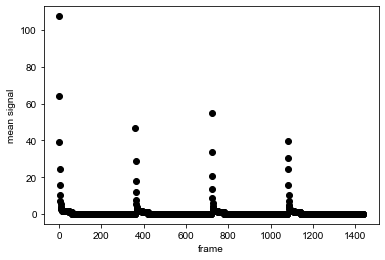

In [4]:
plt.xlabel('frame')
plt.ylabel('mean signal')
plt.plot(np.mean(video[0:], axis = (1,2)), "ko")

distances in pixels for the calibration chart (representing 0.4mm) : 806.7329173896402 805.3620303937851


0.0009924973725647765

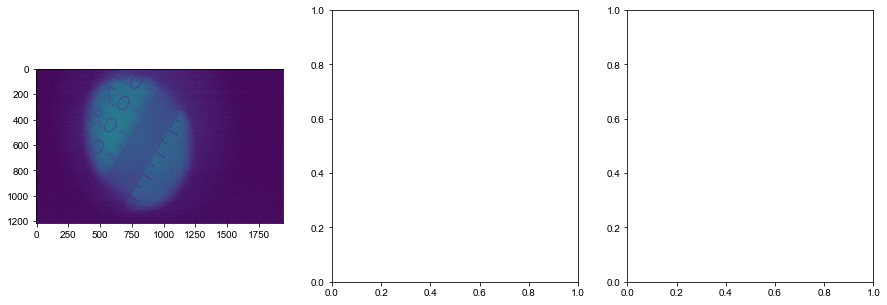

In [5]:
from matplotlib import image

mire = image.imread('../data/epifluorescence/mire.png')
mire[mire>0.3] = 0
fig, axs = plt.subplots(1,3, figsize=(15, 5))
axs[0].imshow(mire*10)

## Pixel positions

x1, x2, x3, x4 = 1150, 737, 930, 518
y1, y2, y3, y4 = 316, 1009, 190, 882

v1 = np.sqrt((x2-x1)**2 + (y2-y1)**2)
v3 = np.sqrt((x4-x3)**2 + (y4-y3)**2)
print("distances in pixels for the calibration chart (representing 0.4mm) :", v1, v3)
ratio = 0.4*2/(v1+v3) #mm


ratio = ratio *2 #(not the same scale for the video and the mire)
ratio

scale bar: 100.24223462904243 µm


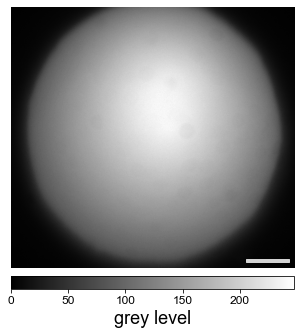

In [6]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=18)

ref = 0#click.prompt("First useful frame", type=int, default=0)


p.set_figure()
plt.axis("off")
image = plt.imshow(video[ref], cmap = "gray")
H, L = video[ref].shape
scale = H//6
rec = matplotlib.patches.Rectangle((H-H//10, L-L//9), scale, L//100, color = "lightgrey")
ax = plt.gca()
ax.add_patch(rec)
divider = make_axes_locatable(plt.gca())
axdef = divider.append_axes("bottom", "5%", pad="3%")
cbar = plt.colorbar(image, cax=axdef, orientation = "horizontal")
ax = plt.gca()
plt.xlabel("grey level", size=p.fontsize)

ax.tick_params(labelsize=p.fonttick)


plt.savefig(p.save_folder + "/epi_intensity" + p.extension)
print("scale bar:", scale*ratio*1e3, 'µm')

In [7]:
H

608

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


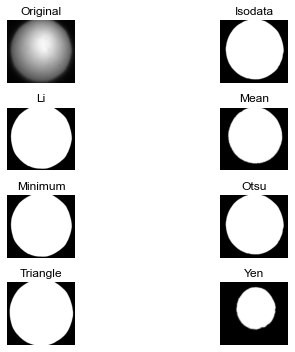

In [8]:
u = skimage.filters.try_all_threshold(video[ref])


In [9]:
threshold_method = threshold_convert("minimum")

#click.prompt("copy the name of the thresholding method that suits you. If none suits, enter None", type = str, default="skimage.filters.thresholding.threshold_minimum"))


minimum


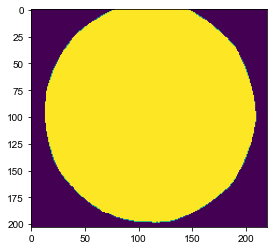

In [10]:
D = 3# click.prompt("smoothing & downscaling factor to accelerate computations", type=int, default=5)

video = np.array(video)
timing = np.linspace(0, len(video)-1, len(video))/framerate #generate time array from framerate
mask = downscale_local_mean(video[ref], (D,D))
threshold = threshold_method(mask)

mask = mask>threshold
plt.imshow(mask)




#downscaling 
video_downscaled = []
for i in range(ref, video.shape[0]):
    video_downscaled.append(downscale_local_mean(video[i], (D, D)))
video_downscaled = np.array(video_downscaled)
init_shape = np.copy(video_downscaled.shape)
L, H = init_shape[1:]
video_2D = np.copy(video_downscaled)
video_downscaled = video_downscaled.reshape(video_downscaled.shape[0], -1)

to_evaluate = video_downscaled[:,mask.flatten()]

0.6314284095844575


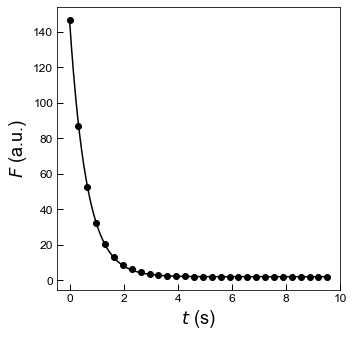

In [16]:
start = 0
stop = 30  #<------ you can select a shorter segment for the fits
#fit on the mean value before performing the fit on each pixel
params = simple_tau(np.mean(to_evaluate[start:stop], axis = 1), timing[start:stop], sample_rate = framerate)


fig = p.set_figure("%d", "%d")
time = timing[start:stop]
plt.plot(time, np.mean(to_evaluate[start:stop], axis = 1), "ok", label = "raw data")
x2 = np.linspace(time.min(), time.max(), 1024)
plt.plot(x2, exp_decay(params, x2), "k", label = "fit")
print(params[1])

plt.xlabel('$t$ (s)')
plt.ylabel("$F$ (a.u.)")
#plt.legend()
plt.savefig(p.save_folder + "epi_mean_decay_fit_D2.pdf")

In [12]:
sat = np.sum(to_evaluate[ref]==255)/len(to_evaluate[ref].flatten())*100
print("percent of saturated pixels in the mask: ", sat)

if sat > 2:
    print("WARNING, more than 2% of the pixels are saturated on the first frame, try acquiring the movie with shorter exposure/smaller gain.")

percent of saturated pixels in the mask:  0.0


In [13]:
#parallel fit on each pixel of the mask
tau_lists = Parallel(n_jobs = -1 )(parallel_tau(to_evaluate[start:stop,i], timing[start:stop], sample_rate = framerate) for i in tqdm(range(to_evaluate.shape[1])))


100%|██████████████████████████████████████████████████████████████████████████| 31278/31278 [00:15<00:00, 2084.54it/s]


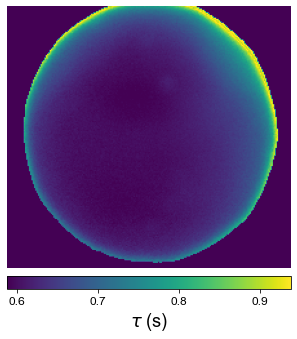

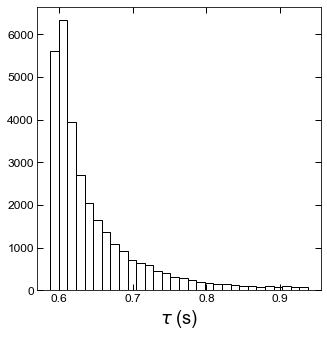

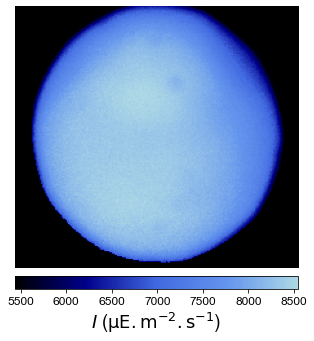

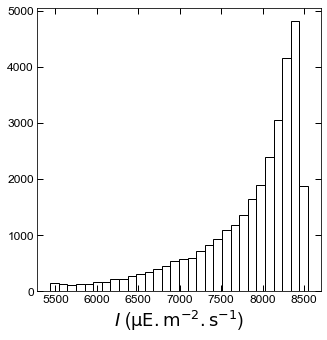

In [14]:
tau_480 = np.array(tau_lists)
tau_480_map = np.zeros(mask.shape)
tau_480_map[mask] = tau_480


I_480 = 1e6*(1/tau_480 - tau_relax)/sigma_480
I_480_map = np.zeros(mask.shape)
I_480_map[mask] = I_480

np.save("../images/I_480_map.npy", I_480_map)

plt.rcParams['image.cmap'] = 'viridis'


I, dis, fig = plot_map(tau_480, tau_480_map,"epi" + "_tau_480_map_B" + p.extension, tau = True, scalebar = False)

I, dis, fig = plot_map(I_480, I_480_map,"epi" + "_I_480_map_B" + p.extension, tau = False, scalebar=False)




np.save("../images/video_2D.npy", video_2D)
np.save("../images/framerate.npy", framerate)


In [15]:
p.save_folder

'G:/DREAM/from_github/thesis/Intensity_paper/'